In [1]:
import time
start = time.perf_counter()

In [2]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import  SARunner, GARunner, RHCRunner, FlipFlopGenerator

/var/folders/jl/f9lzys992qq51pbq0s5hy7pc0000gn/T/ipykernel_96059/3363883037.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML # for some notebook formatting.


In [3]:
N = 5
random_seeds = np.random.randint(0, 903967645, size=N)
sizes = [5, 10, 20, 40, 60, 80]

In [4]:
def run_rhc_with_seeds(seeds, size, max_attempts=100, max_iters=10000):
    all_curves = []
    all_fevals = []
    all_times = []
    
    for seed in seeds:
        problem = FlipFlopGenerator().generate(seed=seed, size=size)
        
        runner = mlrose_hiive.RHCRunner(problem, experiment_name=f'flipflop_rhc_size_{size}',
                                        output_directory=None,
                                        seed=seed,
                                        iteration_list=[max_iters],
                                        max_attempts=max_attempts,
                                        restart_list=[100])
        run_stats, run_curves = runner.run()
        
        best_curve = run_curves
        best_curve.reset_index(inplace=True)
        all_curves.append(best_curve)
        
        # Collect function evaluations and wall clock times
        fevals = run_curves['FEvals']
        times = run_curves['Time']
        all_fevals.append(fevals)
        all_times.append(times)
    
    return all_curves, all_fevals, all_times

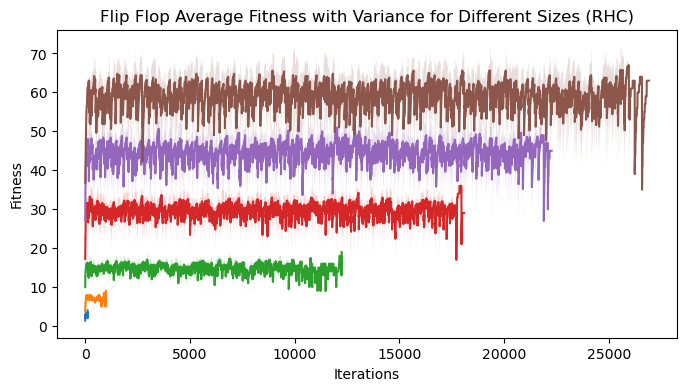

In [5]:
plt.figure(figsize=(8, 4))

for size in sizes:
    all_rhc_curves, all_fevals, all_times = run_rhc_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for fitness
    fitness_arrays = [curve['Fitness'].values for curve in all_rhc_curves]
    max_length = max(len(fitness) for fitness in fitness_arrays)
    padded_fitness_arrays = [np.pad(fitness, (0, max_length - len(fitness)), 'constant', constant_values=np.nan) for fitness in fitness_arrays]
    fitness_matrix = np.array(padded_fitness_arrays)

    # Calculate average and variance
    average_fitness = np.nanmean(fitness_matrix, axis=0)
    variance_fitness = np.nanvar(fitness_matrix, axis=0)

    # Plot the results for fitness
    plt.plot(average_fitness, label=f'Average Fitness Size {size}')
    plt.fill_between(range(max_length), 
                     average_fitness - np.sqrt(variance_fitness), 
                     average_fitness + np.sqrt(variance_fitness), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Fitness with Variance for Different Sizes (RHC)')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend
plt.savefig(f'../images/optimization/flipflop/rhc/average_fitnesss_flipflop_rhc_all_sizes.png')
plt.show()

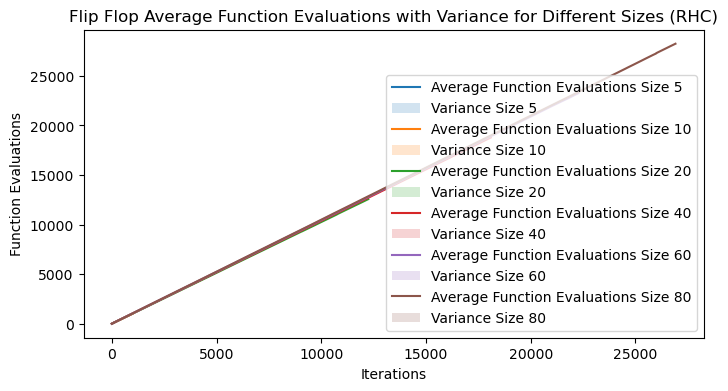

In [6]:
# Plot the results for function evaluations
plt.figure(figsize=(8, 4))

for size in sizes:
    all_rhc_curves, all_fevals, all_times = run_rhc_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for function evaluations
    fevals_arrays = [fevals.values for fevals in all_fevals]
    max_length = max(len(fevals) for fevals in fevals_arrays)
    padded_fevals_arrays = [np.pad(fevals, (0, max_length - len(fevals)), 'constant', constant_values=np.nan) for fevals in fevals_arrays]
    fevals_matrix = np.array(padded_fevals_arrays)

    # Calculate average and variance for function evaluations
    average_fevals = np.nanmean(fevals_matrix, axis=0)
    variance_fevals = np.nanvar(fevals_matrix, axis=0)

    # Plot the results for function evaluations
    plt.plot(average_fevals, label=f'Average Function Evaluations Size {size}')
    plt.fill_between(range(max_length), 
                     average_fevals - np.sqrt(variance_fevals), 
                     average_fevals + np.sqrt(variance_fevals), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Function Evaluations with Variance for Different Sizes (RHC)')
plt.xlabel('Iterations')
plt.ylabel('Function Evaluations')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/rhc/average_function_evaluations_flipflop_rhc_all_sizes.png')
plt.show()

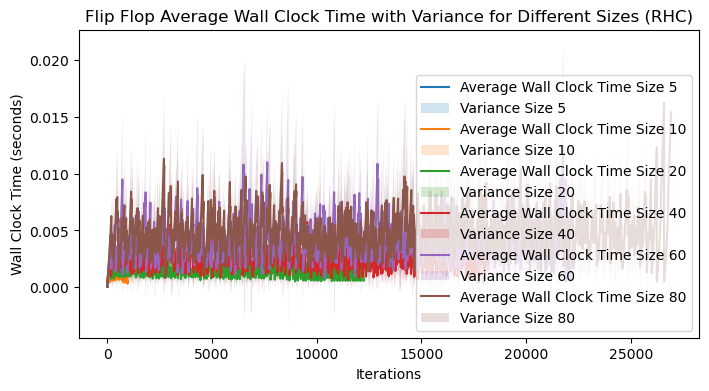

In [7]:
plt.figure(figsize=(8, 4))

for size in sizes:
    all_rhc_curves, all_fevals, all_times = run_rhc_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for wall clock time
    times_arrays = [times.values for times in all_times]
    max_length = max(len(times) for times in times_arrays)
    padded_times_arrays = [np.pad(times, (0, max_length - len(times)), 'constant', constant_values=np.nan) for times in times_arrays]
    times_matrix = np.array(padded_times_arrays)

    # Calculate average and variance for wall clock time
    average_times = np.nanmean(times_matrix, axis=0)
    variance_times = np.nanvar(times_matrix, axis=0)

    # Plot the results for wall clock time
    plt.plot(average_times, label=f'Average Wall Clock Time Size {size}')
    plt.fill_between(range(max_length), 
                     average_times - np.sqrt(variance_times), 
                     average_times + np.sqrt(variance_times), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Wall Clock Time with Variance for Different Sizes (RHC)')
plt.xlabel('Iterations')
plt.ylabel('Wall Clock Time (seconds)')
plt.legend(loc='lower right')
plt.savefig(f'../images/optimization/flipflop/rhc/average_wall_clock_time_flipflop_rhc_all_sizes.png')
plt.show()

In [8]:
def run_sa_with_seeds(seeds, size):
    all_curves = []
    all_fevals = []
    all_times = []
    
    for seed in seeds:
        problem = FlipFlopGenerator().generate(seed=seed, size=size)
        
        runner = mlrose_hiive.SARunner(problem, experiment_name=f'flipflop_sa_size_{size}',
                                       output_directory=None,
                                       seed=seed,
                                       iteration_list=2 ** np.arange(0, 14),
                                       max_attempts=500,
                                       temperature_list=[25],
                                       decay_list=[mlrose_hiive.GeomDecay])
        run_stats, run_curves = runner.run()
        
        best_index_in_curve = run_curves.Fitness.idxmax()
        best_decay = run_curves.iloc[best_index_in_curve].Temperature
        best_curve = run_curves.loc[run_curves.Temperature == best_decay, :]
        best_curve.reset_index(inplace=True)
        all_curves.append(best_curve)
        
        # Collect function evaluations and wall clock times
        fevals = run_curves['FEvals']
        times = run_curves['Time']
        all_fevals.append(fevals)
        all_times.append(times)
    
    return all_curves, all_fevals, all_times

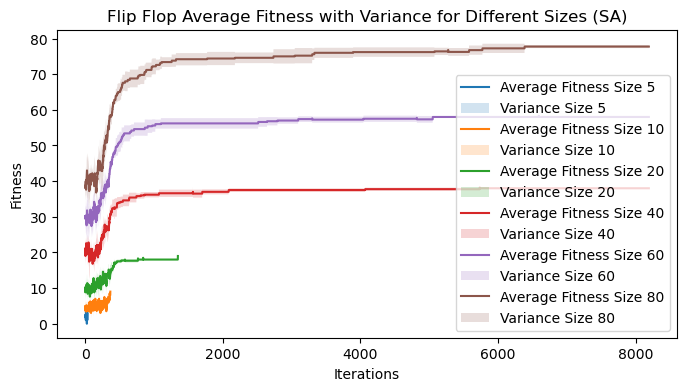

In [9]:
# Plot the results for fitness
plt.figure(figsize=(8, 4))

for size in sizes:
    all_sa_curves, all_sa_fevals, all_sa_times = run_sa_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for fitness
    fitness_arrays = [curve['Fitness'].values for curve in all_sa_curves]
    max_length = max(len(fitness) for fitness in fitness_arrays)
    padded_fitness_arrays = [np.pad(fitness, (0, max_length - len(fitness)), 'constant', constant_values=np.nan) for fitness in fitness_arrays]
    fitness_matrix = np.array(padded_fitness_arrays)

    # Calculate average and variance
    average_fitness = np.nanmean(fitness_matrix, axis=0)
    variance_fitness = np.nanvar(fitness_matrix, axis=0)

    # Plot the results for fitness
    plt.plot(average_fitness, label=f'Average Fitness Size {size}')
    plt.fill_between(range(max_length), 
                     average_fitness - np.sqrt(variance_fitness), 
                     average_fitness + np.sqrt(variance_fitness), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Fitness with Variance for Different Sizes (SA)')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/sa/average_fitness_flipflop_sa_all_sizes.png')
plt.show()

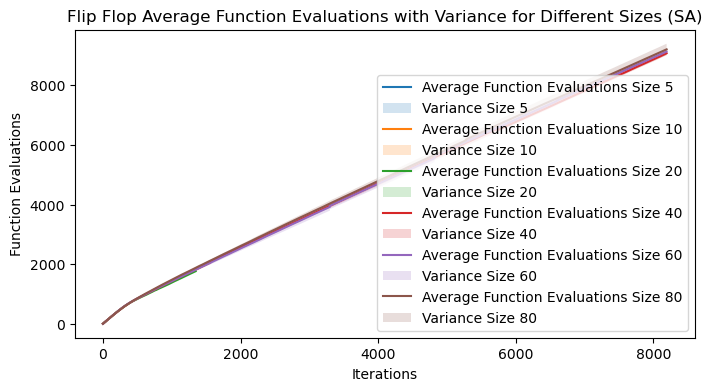

In [10]:
# Plot the results for function evaluations
plt.figure(figsize=(8, 4))

for size in sizes:
    all_sa_curves, all_sa_fevals, all_sa_times = run_sa_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for function evaluations
    fevals_arrays = [fevals.values for fevals in all_sa_fevals]
    max_length = max(len(fevals) for fevals in fevals_arrays)
    padded_fevals_arrays = [np.pad(fevals, (0, max_length - len(fevals)), 'constant', constant_values=np.nan) for fevals in fevals_arrays]
    fevals_matrix = np.array(padded_fevals_arrays)

    # Calculate average and variance for function evaluations
    average_fevals = np.nanmean(fevals_matrix, axis=0)
    variance_fevals = np.nanvar(fevals_matrix, axis=0)

    # Plot the results for function evaluations
    plt.plot(average_fevals, label=f'Average Function Evaluations Size {size}')
    plt.fill_between(range(max_length), 
                     average_fevals - np.sqrt(variance_fevals), 
                     average_fevals + np.sqrt(variance_fevals), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Function Evaluations with Variance for Different Sizes (SA)')
plt.xlabel('Iterations')
plt.ylabel('Function Evaluations')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/sa/average_function_evaluations_flipflop_sa_all_sizes.png')
plt.show()

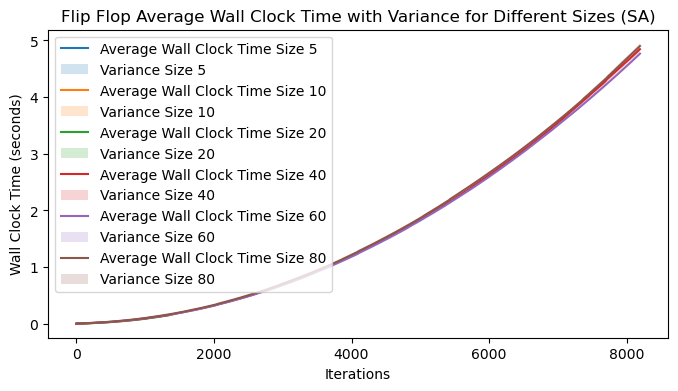

In [11]:
# Plot the results for wall clock time
plt.figure(figsize=(8, 4))

for size in sizes:
    all_sa_curves, all_sa_fevals, all_sa_times = run_sa_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for wall clock time
    times_arrays = [times.values for times in all_sa_times]
    max_length = max(len(times) for times in times_arrays)
    padded_times_arrays = [np.pad(times, (0, max_length - len(times)), 'constant', constant_values=np.nan) for times in times_arrays]
    times_matrix = np.array(padded_times_arrays)

    # Calculate average and variance for wall clock time
    average_times = np.nanmean(times_matrix, axis=0)
    variance_times = np.nanvar(times_matrix, axis=0)

    # Plot the results for wall clock time
    plt.plot(average_times, label=f'Average Wall Clock Time Size {size}')
    plt.fill_between(range(max_length), 
                     average_times - np.sqrt(variance_times), 
                     average_times + np.sqrt(variance_times), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Wall Clock Time with Variance for Different Sizes (SA)')
plt.xlabel('Iterations')
plt.ylabel('Wall Clock Time (seconds)')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/sa/average_wall_clock_time_flipflop_sa.png')
plt.show()


In [12]:
def run_ga_with_seeds(seeds, size, max_attempts=100, max_iters=10000):
    all_curves = []
    all_fevals = []
    all_times = []
    
    for seed in seeds:
        problem = FlipFlopGenerator().generate(seed=seed, size=size)
        
        runner = mlrose_hiive.GARunner(problem, experiment_name=f'flipflop_ga_size_{size}',
                                       output_directory=None,
                                       seed=seed,
                                       iteration_list=2 ** np.arange(0, 14),
                                       max_attempts=max_attempts,
                                       population_sizes=[1000],
                                       mutation_rates=[0.1])
        run_stats, run_curves = runner.run()
        
        # Select the best curve based on the highest fitness
        best_index_in_curve = run_curves.Fitness.idxmax()
        best_curve = run_curves.iloc[best_index_in_curve]
        all_curves.append(run_curves)
        
        # Collect function evaluations and wall clock times
        fevals = run_curves['FEvals'].values
        times = run_curves['Time'].values
        all_fevals.append(fevals)
        all_times.append(times)
    
    return all_curves, all_fevals, all_times

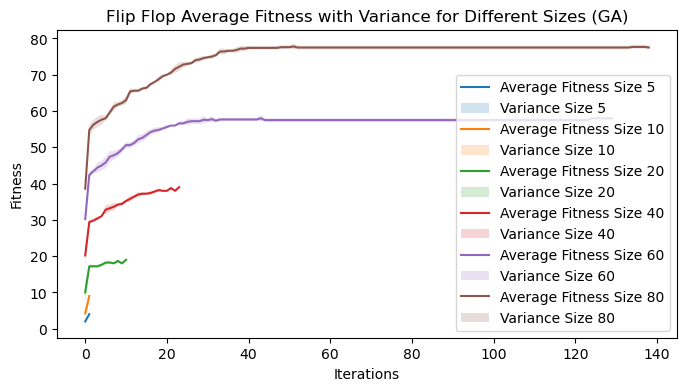

In [13]:
# Plot the results for fitness
plt.figure(figsize=(8, 4))

for size in sizes:
    all_ga_curves, all_ga_fevals, all_ga_times = run_ga_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for fitness
    fitness_arrays = [curve['Fitness'].values for curve in all_ga_curves]
    max_length = max(len(fitness) for fitness in fitness_arrays)
    padded_fitness_arrays = [np.pad(fitness, (0, max_length - len(fitness)), 'constant', constant_values=np.nan) for fitness in fitness_arrays]
    fitness_matrix = np.array(padded_fitness_arrays)

    # Calculate average and variance
    average_fitness = np.nanmean(fitness_matrix, axis=0)
    variance_fitness = np.nanvar(fitness_matrix, axis=0)

    # Plot the results for fitness
    plt.plot(average_fitness, label=f'Average Fitness Size {size}')
    plt.fill_between(range(max_length), 
                     average_fitness - np.sqrt(variance_fitness), 
                     average_fitness + np.sqrt(variance_fitness), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Fitness with Variance for Different Sizes (GA)')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/ga/average_fitness_flipflop_ga_all_sizes.png')
plt.show()

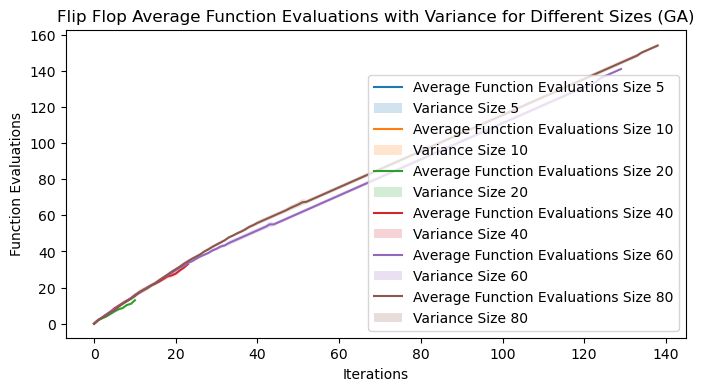

In [14]:
# Plot the results for function evaluations
plt.figure(figsize=(8, 4))

for size in sizes:
    all_ga_curves, all_ga_fevals, all_ga_times = run_ga_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for function evaluations
    fevals_arrays = [fevals for fevals in all_ga_fevals]
    max_length = max(len(fevals) for fevals in fevals_arrays)
    padded_fevals_arrays = [np.pad(fevals, (0, max_length - len(fevals)), 'constant', constant_values=np.nan) for fevals in fevals_arrays]
    fevals_matrix = np.array(padded_fevals_arrays)

    # Calculate average and variance for function evaluations
    average_fevals = np.nanmean(fevals_matrix, axis=0)
    variance_fevals = np.nanvar(fevals_matrix, axis=0)

    # Plot the results for function evaluations
    plt.plot(average_fevals, label=f'Average Function Evaluations Size {size}')
    plt.fill_between(range(max_length), 
                     average_fevals - np.sqrt(variance_fevals), 
                     average_fevals + np.sqrt(variance_fevals), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Function Evaluations with Variance for Different Sizes (GA)')
plt.xlabel('Iterations')
plt.ylabel('Function Evaluations')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/ga/average_function_evaluations_flipflop_ga_all_sizes.png')
plt.show()

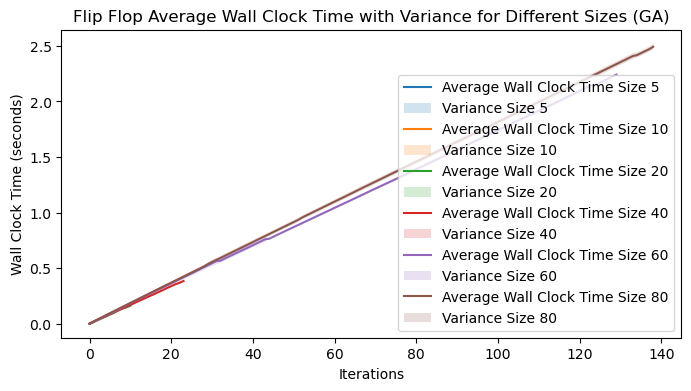

In [15]:
# Plot the results for wall clock time
plt.figure(figsize=(8, 4))

for size in sizes:
    all_ga_curves, all_ga_fevals, all_ga_times = run_ga_with_seeds(seeds=random_seeds, size=size)

    # Aggregate the results for wall clock time
    times_arrays = [times for times in all_ga_times]
    max_length = max(len(times) for times in times_arrays)
    padded_times_arrays = [np.pad(times, (0, max_length - len(times)), 'constant', constant_values=np.nan) for times in times_arrays]
    times_matrix = np.array(padded_times_arrays)

    # Calculate average and variance for wall clock time
    average_times = np.nanmean(times_matrix, axis=0)
    variance_times = np.nanvar(times_matrix, axis=0)

    # Plot the results for wall clock time
    plt.plot(average_times, label=f'Average Wall Clock Time Size {size}')
    plt.fill_between(range(max_length), 
                     average_times - np.sqrt(variance_times), 
                     average_times + np.sqrt(variance_times), 
                     alpha=0.2, label=f'Variance Size {size}')

plt.title('Flip Flop Average Wall Clock Time with Variance for Different Sizes (GA)')
plt.xlabel('Iterations')
plt.ylabel('Wall Clock Time (seconds)')
plt.legend()
plt.savefig(f'../images/optimization/flipflop/ga/average_wall_clock_time_flipflop_ga_all_sizes.png')
plt.show()

In [16]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 3.7996223007000176
